# Imports

In [1]:
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sn
sn.set(font_scale=1.4) # for label size
import multiprocessing as mp
import csv

# Load DataSet

0 means unlikely to have flood damage, 1 means likely to have flood damage

[0,1] --> damage

[1,0] --> no damage

## Load Training Set

In [2]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_train = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_train = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffler]
y_train = y_train[shuffler]

## Load Validation Set

In [3]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_val = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_val = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_val = X_val[shuffler]
y_val = y_val[shuffler]

In [4]:
# combine training and validation data - for cross-validation
X_all = np.concatenate((X_train, X_val))
y_all = np.concatenate((y_train, y_val))

## Load Test Set

In [5]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_test = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_test = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_test = X_test[shuffler]
y_test = y_test[shuffler]

## Input/Output

In [6]:
# save a dictionary as a csv file
def output_as_csv(name, a):
    path = "/kaggle/working/" + name + ".csv"
    with open(path, 'w') as csv_file:
        # create the csv writer
        writer = csv.writer(csv_file)

        # write a row to the csv file
        writer.writerow(a.keys())
        writer.writerow(a.values())

# input a csv file
def input_csv(path):
    b, keys = {}, {}
    with open(path, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0
        for row in csv_reader:
            keys = row
    b = dict(keys)
    return b # returns a dictionary

# Pre-Process DataSet

In [6]:
# pre-process data 
def scale_pixels(train, val, test, X_all):
	# convert from integers to floats and normalize between 0-1
  train_norm = train.astype('float32') / 255.0
  val_norm = val.astype('float32') / 255.0
  test_norm = test.astype('float32') / 255.0
  X_all_norm = X_all.astype('float32') / 255.0
	# return normalized images
  return train_norm, val_norm, test_norm, X_all_norm

X_train, X_val, X_test, X_all = scale_pixels(X_train, X_val, X_test, X_all)

# Plot Diagnostics

In [7]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # blue = training data; orange = validation data
	# plot validation loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='validation')

In [9]:
# returns the confusion matrix
def find_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_val = y_pred.argmax(axis=1)
    y_test_val = y_test.argmax(axis=1)
    return confusion_matrix(y_test_val, y_pred_val)

# returns the confusion matrix based on tn, fn, fp, tp
def find_confusion_matrix_2(tn, fn, fp, tp):
    return [[tn, fp], [fn, tp]]

# generate heat map for confusion matrix
def heatmap(confusion_matrix):
    df = pd.DataFrame(confusion_matrix, index = ['F', 'T'], columns = ['F', 'T'])
    sn.heatmap(df, annot=True) # create a heatmap
    
# returns normalized confusion matrix
def normalize_confusion_matrix(confusion_matrix):
    confusion_matrix = np.array(confusion_matrix)
    confusion_matrix_sum = confusion_matrix.astype(np.float).sum(axis=1)
    confusion_matrix_norm = confusion_matrix.astype(np.float)
    confusion_matrix_norm[0] = confusion_matrix_norm[0] / confusion_matrix_sum[0]
    confusion_matrix_norm[1] = confusion_matrix_norm[1] / confusion_matrix_sum[1]
    return confusion_matrix_norm

def print_confusion_matrix_results(results):
    # results is a dictionary
    # calculate mean and standard deviation for each key
    for key in results:
        mean = np.mean(results[key])
        std = np.std(results[key])
        print("{} mean: {}".format(key, mean))
        print("{} std: {}".format(key, std))

# Create CNN Model

In [8]:
# define cnn model
def define_model(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Batch Normalization

In [ ]:
# define cnn model
def define_model_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Dropout Regularization

In [ ]:
# define cnn model
def define_model_dropout_regularization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2)) # retain 80% of neurons
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

### CNN Model with Dropout Regularization and Batch Normalization

In [ ]:
# define cnn model
def define_model_dropout_regularization_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2)) # retain 80% of neurons
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Weight Regularization

In [9]:
# define cnn model
def define_model_weight_regularization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

### CNN Model with Weight Regularization and Batch Normalization

In [9]:
# define cnn model
def define_model_weight_regularization_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [8]:
# define cnn model
def define_model_weight_regularization_batch_normalization2(learning_rate, regularization_lambda):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(regularization_lambda), input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(regularization_lambda)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(regularization_lambda)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(regularization_lambda)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(regularization_lambda)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(regularization_lambda)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(regularization_lambda)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# Train Data
Hyperparameters are inputted into the function

In [ ]:
def train(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data w/ Cross Validation

In [ ]:
def benchmark_model(X_all, y_all, split):
    X_train_cv, y_train_cv = X_all[split[0]], y_all[split[0]]
    X_val_cv, y_val_cv = X_all[split[1]], y_all[split[1]]
    model, accuracy = train(X_train_cv, X_val_cv, X_val_cv, y_train_cv, y_val_cv, y_val_cv, 0.001, 75) 
    results = {}
#     results["model"] = model
    results["accuracy"] = accuracy
    results["confusion_matrix"] = find_confusion_matrix(model, X_val_cv, y_val_cv)
    tn, fp, fn, tp = results["confusion_matrix"].ravel()
    results["tn"] = tn
    results["fp"] = fp
    results["fn"] = fn
    results["tp"] = tp
    results["TPR/Recall"] = tp/(tp+fn)
    results["TNR/Specificity"] = tn/(tn+fp)
    results["PPV/Precision"] = tp/(tp+fp)
    results["NPV"] = tn/(tn+fn)
    return results

In [ ]:
kf = KFold(n_splits=5)
folds = list(kf.split(X_all, y_all))

In [ ]:
output_as_csv("normal_fold_1", benchmark_model(X_all, y_all, folds[0]))

In [ ]:
output_as_csv("normal_fold_2", benchmark_model(X_all, y_all, folds[1]))

In [ ]:
output_as_csv("normal_fold_3", benchmark_model(X_all, y_all, folds[2]))

In [ ]:
output_as_csv("normal_fold_4", benchmark_model(X_all, y_all, folds[3]))

In [ ]:
output_as_csv("normal_fold_5", benchmark_model(X_all, y_all, folds[4]))

In [ ]:
# results_list is a list of dictionaries
results_list = []
for i in range(1,6):
    path = "../input/hurricane-normal-cv/normal_fold_" + str(i) + ".csv"
    results_list.append(input_csv(path))

# results_dict is a dictionary of lists
results_dict = {}
results_dict["accuracy"] = [(float)(i["accuracy"]) for i in results_list]
results_dict["TPR/Recall"] = [(float)(i["TPR/Recall"]) for i in results_list]
results_dict["TNR/Specificity"] = [(float)(i["TNR/Specificity"]) for i in results_list]
results_dict["PPV/Precision"] = [(float)(i["PPV/Precision"]) for i in results_list]
results_dict["NPV"] = [(float)(i["NPV"]) for i in results_list]

print_confusion_matrix_results(results_dict)

In [ ]:
# find confusion matrices
results_dict["tn"] = [(int)(i["tn"]) for i in results_list]
results_dict["fp"] = [(int)(i["fp"]) for i in results_list]
results_dict["fn"] = [(int)(i["fn"]) for i in results_list]
results_dict["tp"] = [(int)(i["tp"]) for i in results_list]
results_dict["confusion_matrix"] = []
# append confusion matrix for each cross-validation fold
for i in range(len(folds)):
    results_dict["confusion_matrix"].append(find_confusion_matrix_2(results_dict["tn"][i], results_dict["fp"][i], results_dict["fn"][i], results_dict["tp"][i]))
                                            
# total confusion matrix summed together
confusion_matrix_list = []
confusion_matrix_list = results_dict["confusion_matrix"]
confusion_matrix_comb = np.sum(confusion_matrix_list, axis=0)
heatmap(confusion_matrix_comb)

In [ ]:
# normalized confusion matrix
confusion_matrix_norm = normalize_confusion_matrix(confusion_matrix_comb)
heatmap(confusion_matrix_norm)

## Train Data with Batch Normalization

In [ ]:
def train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Tune Hyperparameters - learning rate

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.0005, 75)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.005, 40)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.01, 40)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.1, 40)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Tune Hyperparameters - batch size

In [ ]:
def train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, batch_size, epochs):
  # define model
  model = define_model_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.005, 128, 40)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.005, 32, 40)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.005, 256, 40)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Train Data with Batch Normalization and Cross Validation 

In [ ]:
def benchmark_model_batch_normalization(X_all, y_all, split):
    X_train_cv, y_train_cv = X_all[split[0]], y_all[split[0]]
    X_val_cv, y_val_cv = X_all[split[1]], y_all[split[1]]
    model, accuracy = train_batch_normalization(X_train_cv, X_val_cv, X_val_cv, y_train_cv, y_val_cv, y_val_cv, 0.001, 40) 
    results = {}
#     results["model"] = model
    results["accuracy"] = accuracy
    results["confusion_matrix"] = find_confusion_matrix(model, X_val_cv, y_val_cv)
    tn, fp, fn, tp = results["confusion_matrix"].ravel()
    results["tn"] = tn
    results["fp"] = fp
    results["fn"] = fn
    results["tp"] = tp
    results["TPR/Recall"] = tp/(tp+fn)
    results["TNR/Specificity"] = tn/(tn+fp)
    results["PPV/Precision"] = tp/(tp+fp)
    results["NPV"] = tn/(tn+fn)
    return results

In [ ]:
kf = KFold(n_splits=5)
folds = list(kf.split(X_all, y_all))

In [ ]:
output_as_csv("batch normalization fold 1", benchmark_model_batch_normalization(X_all, y_all, folds[0]))

In [ ]:
output_as_csv("batch normalization fold 2", benchmark_model_batch_normalization(X_all, y_all, folds[1]))

In [ ]:
output_as_csv("batch normalization fold 3", benchmark_model_batch_normalization(X_all, y_all, folds[2]))

In [ ]:
output_as_csv("batch normalization fold 4", benchmark_model_batch_normalization(X_all, y_all, folds[3]))

In [ ]:
output_as_csv("batch normalization fold 5", benchmark_model_batch_normalization(X_all, y_all, folds[4]))

In [ ]:
# results_list is a list of dictionaries
results_list = []
for i in range(1,6):
    path = "../input/hurricane-vgg-batch-cv/batch normalization fold " + str(i) + ".csv"
    results_list.append(input_csv(path))

# results_dict is a dictionary of lists
results_dict = {}
results_dict["accuracy"] = [(float)(i["accuracy"]) for i in results_list]
results_dict["TPR/Recall"] = [(float)(i["TPR/Recall"]) for i in results_list]
results_dict["TNR/Specificity"] = [(float)(i["TNR/Specificity"]) for i in results_list]
results_dict["PPV/Precision"] = [(float)(i["PPV/Precision"]) for i in results_list]
results_dict["NPV"] = [(float)(i["NPV"]) for i in results_list]

print_confusion_matrix_results(results_dict)

In [ ]:
# find confusion matrices
results_dict["tn"] = [(int)(i["tn"]) for i in results_list]
results_dict["fp"] = [(int)(i["fp"]) for i in results_list]
results_dict["fn"] = [(int)(i["fn"]) for i in results_list]
results_dict["tp"] = [(int)(i["tp"]) for i in results_list]
results_dict["confusion_matrix"] = []
# append confusion matrix for each cross-validation fold
for i in range(len(folds)):
    results_dict["confusion_matrix"].append(find_confusion_matrix_2(results_dict["tn"][i], results_dict["fp"][i], results_dict["fn"][i], results_dict["tp"][i]))
                                            
# total confusion matrix summed together
confusion_matrix_list = []
confusion_matrix_list = results_dict["confusion_matrix"]
confusion_matrix_comb = np.sum(confusion_matrix_list, axis=0)
heatmap(confusion_matrix_comb)

In [ ]:
# normalized confusion matrix
confusion_matrix_norm = normalize_confusion_matrix(confusion_matrix_comb)
heatmap(confusion_matrix_norm)

## Train Data with Data Augmentation

In [ ]:
def train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=8, verbose=1)
	# fit model
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 50)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Train Data with Data Augmentation and Batch Normalization

In [ ]:
def train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_batch_normalization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_augmentation_batch_normalization, accuracy = train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)
y_pred = model_test_data_augmentation_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Dropout Regularization and Batch Normalization

In [ ]:
def train_data_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_dropout_regularization_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_dropout_batch_normalization, accuracy = train_data_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 40)
print(accuracy)
y_pred = model_test_data_dropout_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Train Data with Data Augmentation, Dropout Regularization and Batch Normalization

In [ ]:
def train_data_augmentation_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization_batch_normalization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_dropout_batch_normalization, accuracy = train_data_augmentation_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 25)
print(accuracy)
y_pred = model_test_data_dropout_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Weight Regularization and Batch Normalization

In [12]:
def train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_weight_batch_normalization, accuracy = train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 40)
print(accuracy)
y_pred = model_test_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_weight_batch_normalization, accuracy = train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.01, 40)
print(accuracy)
y_pred = model_test_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_weight_batch_normalization, accuracy = train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.003, 40)
print(accuracy)
y_pred = model_test_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_weight_batch_normalization, accuracy = train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.002, 40)
print(accuracy)
y_pred = model_test_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_weight_batch_normalization, accuracy = train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.0009, 40)
print(accuracy)
y_pred = model_test_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [13]:
def train_data_weight_batch2(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, regularization_lambda, epochs):
  # define model
  model = define_model_weight_regularization_batch_normalization2(learning_rate, regularization_lambda)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

Epoch 1/40
157/157 [==============================] - 759s 5s/step - loss: 1.5700 - accuracy: 0.8383 - val_loss: 4.5210 - val_accuracy: 0.5000
Epoch 2/40
157/157 [==============================] - 767s 5s/step - loss: 1.2635 - accuracy: 0.9597 - val_loss: 3.3253 - val_accuracy: 0.5105
Epoch 3/40
157/157 [==============================] - 761s 5s/step - loss: 1.2246 - accuracy: 0.9749 - val_loss: 1.5972 - val_accuracy: 0.7935
Epoch 4/40
157/157 [==============================] - 779s 5s/step - loss: 1.1955 - accuracy: 0.9843 - val_loss: 1.2646 - val_accuracy: 0.9540
Epoch 5/40
157/157 [==============================] - 791s 5s/step - loss: 1.1762 - accuracy: 0.9897 - val_loss: 1.2351 - val_accuracy: 0.9605
Epoch 6/40
157/157 [==============================] - 782s 5s/step - loss: 1.1580 - accuracy: 0.9933 - val_loss: 1.2599 - val_accuracy: 0.9595
Epoch 7/40
157/157 [==============================] - 768s 5s/step - loss: 1.1492 - accuracy: 0.9934 - val_loss: 1.2063 - val_accuracy: 0.9610

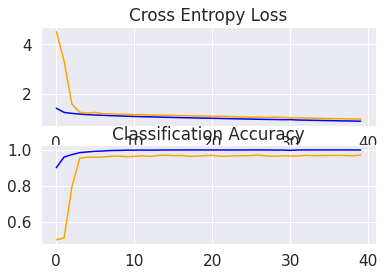

In [13]:
model_test_weight_batch_normalization, accuracy = train_data_weight_batch2(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 0.001, 40)
print(accuracy)
y_pred = model_test_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/40
157/157 [==============================] - 737s 5s/step - loss: 0.4536 - accuracy: 0.8688 - val_loss: 2.9582 - val_accuracy: 0.5000
Epoch 2/40
157/157 [==============================] - 728s 5s/step - loss: 0.2153 - accuracy: 0.9673 - val_loss: 1.3400 - val_accuracy: 0.5865
Epoch 3/40
157/157 [==============================] - 734s 5s/step - loss: 0.1845 - accuracy: 0.9770 - val_loss: 0.3290 - val_accuracy: 0.9130
Epoch 4/40
157/157 [==============================] - 729s 5s/step - loss: 0.1613 - accuracy: 0.9901 - val_loss: 0.2493 - val_accuracy: 0.9525
Epoch 5/40
157/157 [==============================] - 730s 5s/step - loss: 0.1561 - accuracy: 0.9890 - val_loss: 0.2204 - val_accuracy: 0.9655
Epoch 6/40
157/157 [==============================] - 731s 5s/step - loss: 0.1416 - accuracy: 0.9949 - val_loss: 0.2176 - val_accuracy: 0.9700
Epoch 7/40
157/157 [==============================] - 727s 5s/step - loss: 0.1403 - accuracy: 0.9962 - val_loss: 0.2147 - val_accuracy: 0.9620

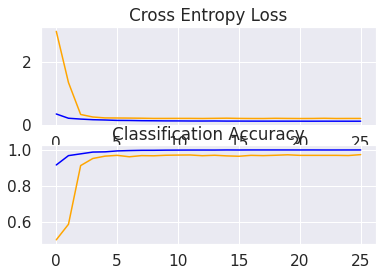

In [14]:
model_test_weight_batch_normalization, accuracy = train_data_weight_batch2(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 0.0001, 40)
print(accuracy)
y_pred = model_test_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Train Data with Data Augmentation, Weight Regularization and Batch Normalization

In [ ]:
def train_data_augmentation_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization_batch_normalization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_weight_batch_normalization, accuracy = train_data_augmentation_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 30)
print(accuracy)
y_pred = model_test_data_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_data_weight_batch_normalization, accuracy = train_data_augmentation_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.01, 40)
print(accuracy)
y_pred = model_test_data_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_data_weight_batch_normalization, accuracy = train_data_augmentation_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.003, 40)
print(accuracy)
y_pred = model_test_data_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [9]:
def train_data_augmentation_weight_batch2(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, regularization_lambda, epochs):
  # define model
  model = define_model_weight_regularization_batch_normalization2(learning_rate, regularization_lambda)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

Epoch 1/35
156/156 [==============================] - 677s 4s/step - loss: 1.5454 - accuracy: 0.8499 - val_loss: 3.9850 - val_accuracy: 0.5000
Epoch 2/35
156/156 [==============================] - 672s 4s/step - loss: 1.3105 - accuracy: 0.9339 - val_loss: 2.3489 - val_accuracy: 0.5330
Epoch 3/35
156/156 [==============================] - 673s 4s/step - loss: 1.2782 - accuracy: 0.9460 - val_loss: 1.3423 - val_accuracy: 0.9240
Epoch 4/35
156/156 [==============================] - 680s 4s/step - loss: 1.2541 - accuracy: 0.9533 - val_loss: 1.2540 - val_accuracy: 0.9505
Epoch 5/35
156/156 [==============================] - 677s 4s/step - loss: 1.2358 - accuracy: 0.9569 - val_loss: 1.2522 - val_accuracy: 0.9515
Epoch 6/35
156/156 [==============================] - 685s 4s/step - loss: 1.2217 - accuracy: 0.9597 - val_loss: 1.2255 - val_accuracy: 0.9595
Epoch 7/35
156/156 [==============================] - 685s 4s/step - loss: 1.2065 - accuracy: 0.9628 - val_loss: 1.2482 - val_accuracy: 0.9490

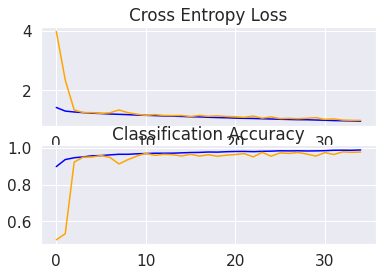

In [13]:
model_test_data_weight, accuracy = train_data_augmentation_weight_batch2(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 0.001, 35)
print(accuracy)
y_pred = model_test_data_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/35
156/156 [==============================] - 769s 5s/step - loss: 102.5534 - accuracy: 0.8317 - val_loss: 66.2458 - val_accuracy: 0.5000
Epoch 2/35
156/156 [==============================] - 763s 5s/step - loss: 54.7443 - accuracy: 0.9354 - val_loss: 36.7236 - val_accuracy: 0.5000
Epoch 3/35
156/156 [==============================] - 757s 5s/step - loss: 29.0394 - accuracy: 0.9525 - val_loss: 21.0593 - val_accuracy: 0.5000
Epoch 4/35
156/156 [==============================] - 756s 5s/step - loss: 15.4559 - accuracy: 0.9530 - val_loss: 11.0035 - val_accuracy: 0.4910
Epoch 5/35
156/156 [==============================] - 758s 5s/step - loss: 8.2761 - accuracy: 0.9489 - val_loss: 6.2928 - val_accuracy: 0.5930
Epoch 6/35
156/156 [==============================] - 757s 5s/step - loss: 4.4645 - accuracy: 0.9553 - val_loss: 4.2693 - val_accuracy: 0.5300
Epoch 7/35
156/156 [==============================] - 762s 5s/step - loss: 2.4433 - accuracy: 0.9608 - val_loss: 1.6678 - val_accurac

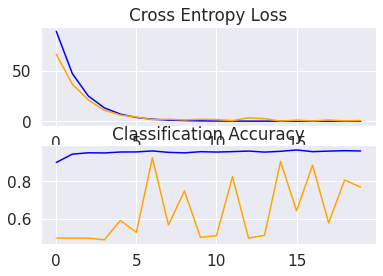

In [11]:
model_test_data_weight, accuracy = train_data_augmentation_weight_batch2(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 0.1, 35)
print(accuracy)
y_pred = model_test_data_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/35
156/156 [==============================] - 758s 5s/step - loss: 0.5089 - accuracy: 0.8490 - val_loss: 4.6159 - val_accuracy: 0.5000
Epoch 2/35
156/156 [==============================] - 767s 5s/step - loss: 0.2694 - accuracy: 0.9423 - val_loss: 3.9359 - val_accuracy: 0.5000
Epoch 3/35
156/156 [==============================] - 761s 5s/step - loss: 0.2381 - accuracy: 0.9544 - val_loss: 0.5735 - val_accuracy: 0.8000
Epoch 4/35
156/156 [==============================] - 754s 5s/step - loss: 0.2321 - accuracy: 0.9600 - val_loss: 0.2653 - val_accuracy: 0.9425
Epoch 5/35
156/156 [==============================] - 753s 5s/step - loss: 0.2172 - accuracy: 0.9635 - val_loss: 0.2595 - val_accuracy: 0.9455
Epoch 6/35
156/156 [==============================] - 772s 5s/step - loss: 0.2054 - accuracy: 0.9693 - val_loss: 0.2272 - val_accuracy: 0.9585
Epoch 7/35
156/156 [==============================] - 756s 5s/step - loss: 0.2074 - accuracy: 0.9650 - val_loss: 0.2175 - val_accuracy: 0.9620

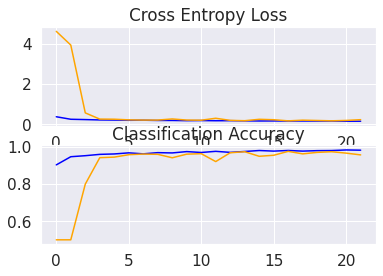

In [10]:
model_test_data_weight, accuracy = train_data_augmentation_weight_batch2(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 0.0001, 35)
print(accuracy)
y_pred = model_test_data_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/35
156/156 [==============================] - 790s 5s/step - loss: 2.0029 - accuracy: 0.5520 - val_loss: 1.9377 - val_accuracy: 0.5315
Epoch 2/35
156/156 [==============================] - 781s 5s/step - loss: 1.8600 - accuracy: 0.6874 - val_loss: 1.8576 - val_accuracy: 0.6455
Epoch 3/35
156/156 [==============================] - 768s 5s/step - loss: 1.7837 - accuracy: 0.7413 - val_loss: 1.7626 - val_accuracy: 0.7445
Epoch 4/35
156/156 [==============================] - 796s 5s/step - loss: 1.7470 - accuracy: 0.7721 - val_loss: 1.7140 - val_accuracy: 0.8160
Epoch 5/35
156/156 [==============================] - 784s 5s/step - loss: 1.7236 - accuracy: 0.7761 - val_loss: 1.7150 - val_accuracy: 0.8310
Epoch 6/35
156/156 [==============================] - 776s 5s/step - loss: 1.6857 - accuracy: 0.8034 - val_loss: 1.7047 - val_accuracy: 0.8345
Epoch 7/35
156/156 [==============================] - 795s 5s/step - loss: 1.6672 - accuracy: 0.8104 - val_loss: 1.6938 - val_accuracy: 0.8400

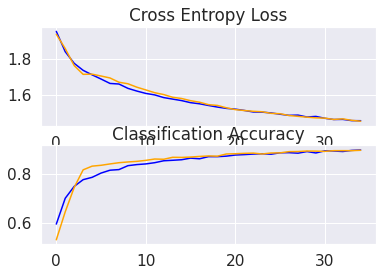

In [11]:
model_test_data_weight, accuracy = train_data_augmentation_weight_batch2(X_train, X_val, X_test, y_train, y_val, y_test, 5e-6, 0.001, 35)
print(accuracy)
y_pred = model_test_data_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))